## 1.Environment Setup & Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from surprise import NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Define path
data_path = 'datasets/student_grade.csv'



In [ ]:
df = pd.read_csv(data_path, low_memory=False)
df

## 2.Data Loading & Preprocessing

In [2]:
# Check if file exists
if not os.path.exists(data_path):
    print(f"Error: The file '{data_path}' was not found.")
else:
    print("File found. Loading data...")

    # === 2.1 Load Data ===
    df = pd.read_csv(data_path, low_memory=False)

    # === 2.2 Transform Data (Wide to Long) ===
    id_vars = ['student_id']
    df_long = pd.melt(df, id_vars=id_vars, var_name='course', value_name='grade')

    # === 2.3 Clean Data ===
    # Convert grade to numeric and remove invalid/empty grades
    df_long['grade'] = pd.to_numeric(df_long['grade'], errors='coerce')
    df_long_cleaned = df_long[(df_long['grade'] > 0.0) & (df_long['grade'].notna())].copy()

    # === 2.4 Filter for 'INT' Courses Only ===
    # This ensures the model only learns from INT courses
    df_long_filtered = df_long_cleaned[df_long_cleaned['course'].astype(str).str.startswith('INT')].copy()

    print(f"--- Data Preparation Complete ---")
    print(f"Total records after cleaning: {len(df_long_cleaned)}")
    print(f"Filtered to INT courses only: {len(df_long_filtered)}")
    display(df_long_filtered)


File found. Loading data...
--- Data Preparation Complete ---
Total records after cleaning: 43104
Filtered to INT courses only: 17468


,student_id,course,grade
25871,A246,INT102 WEB TECHNOLOGY,1.5
27143,A632,INT102 WEB TECHNOLOGY,3.0
27144,A086,INT102 WEB TECHNOLOGY,4.0
27145,A662,INT102 WEB TECHNOLOGY,4.0
27146,A066,INT102 WEB TECHNOLOGY,2.5
...,...,...,...
592988,A385,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,3.5
592990,A424,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593003,A111,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593005,A627,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5


## 3.Split Data to train and test set


In [3]:
# === 3.1 Load Data into Surprise Dataset ===
# Define rating scale (assuming grades are 1.0 to 4.0)
reader = Reader(rating_scale=(1, 4))
data = Dataset.load_from_df(df_long_filtered[['student_id', 'course', 'grade']], reader)


# # === 3.2 Split Data ===
trainset, testset = train_test_split(data, test_size=0.30, random_state=42)

## 4.Model Training (NMF)

In [4]:
print("--- Training SVD Model ---")
model = NMF(
    n_factors = 130,
    n_epochs  = 90,
    reg_pu    = 0.04,
    reg_qi   = 0.08,
    random_state = 42
)
# model = NMF(
#     n_factors = 130,
#     n_epochs  = 110,
#     reg_pu    = 0.04,
#     reg_qi   = 0.04,
#     random_state = 42
# )
model.fit(trainset)
print("Training complete.")



--- Training SVD Model ---
Training complete.


## 5.Test and evaluate model

In [5]:
# === 3.4 Evaluate Performance ===
print("\n--- Model Evaluation ---")
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


--- Model Evaluation ---
RMSE: 0.5723
MAE:  0.4517


## 6.Confusion Matrix and Classification_report

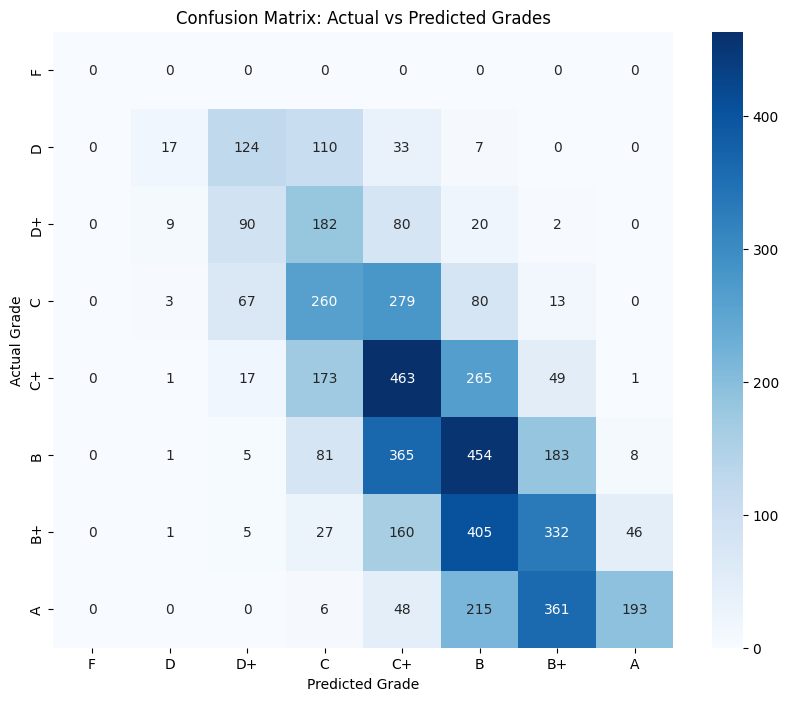


--- Detailed Classification Report ---
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         0
           D       0.53      0.06      0.11       291
          D+       0.29      0.23      0.26       383
           C       0.31      0.37      0.34       702
          C+       0.32      0.48      0.39       969
           B       0.31      0.41      0.36      1097
          B+       0.35      0.34      0.35       976
           A       0.78      0.23      0.36       823

    accuracy                           0.35      5241
   macro avg       0.36      0.27      0.27      5241
weighted avg       0.41      0.35      0.34      5241



In [6]:
# 1. Define Mapping: Score -> Letter
# ต้องเรียงลำดับจากน้อยไปมาก เพื่อให้ Matrix สวยงาม
score_to_letter = {
    0.0: 'F', 1.0: 'D', 1.5: 'D+', 2.0: 'C', 2.5: 'C+',
    3.0: 'B', 3.5: 'B+', 4.0: 'A'
}

# สร้าง list ของเกรดที่เป็นไปได้ (เอาไว้ระบุ Labels)
# กรองเอาเฉพาะที่มีใน map (เผื่อกรณีข้อมูลไม่มี F)
valid_scores = sorted(score_to_letter.keys())
valid_labels = [score_to_letter[s] for s in valid_scores]

# 2. Helper function: หาเกรดที่ใกล้ที่สุด
def get_nearest_grade_key(pred_score):
    # หา key (คะแนน) ที่ใกล้ที่สุด
    return min(valid_scores, key=lambda x: abs(x - pred_score))

# 3. Prepare Data
y_true_letters = []
y_pred_letters = []

for pred in predictions:
    # 3.1 แปลง Actual Grade (r_ui) เป็น Letter
    # ใช้ get_nearest_grade_key เผื่อค่า r_ui มีทศนิยมเพี้ยนเล็กน้อย
    true_score_key = get_nearest_grade_key(pred.r_ui)
    y_true_letters.append(score_to_letter[true_score_key])

    # 3.2 แปลง Predicted Grade (est) เป็น Letter
    pred_score_key = get_nearest_grade_key(pred.est)
    y_pred_letters.append(score_to_letter[pred_score_key])

# 4. Generate Confusion Matrix
# สำคัญ: ต้องใส่ labels=valid_labels เพื่อบังคับลำดับ (D -> A)
cm = confusion_matrix(y_true_letters, y_pred_letters, labels=valid_labels)

# 5. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid_labels,
            yticklabels=valid_labels)

plt.title('Confusion Matrix: Actual vs Predicted Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.show()

# 6. Classification Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true_letters, y_pred_letters, target_names=valid_labels, zero_division=0, labels=valid_labels))

## 6.1 Confusion Matrix and Threshold


--- Model Evaluation ---
RMSE : 0.5723
MAE  : 0.4517
R²   : 0.5522

--- Classification Metrics ---
Precision (macro)   : 0.7694
Recall    (macro)   : 0.7504
F1-score  (macro)   : 0.7305

Precision (weighted): 0.7830
Recall    (weighted): 0.7327
F1-score  (weighted): 0.7280


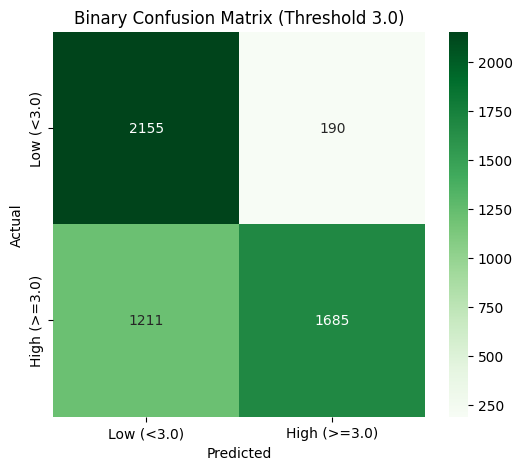

In [ ]:
# === 3.4 Evaluate Performance ===
print("\n--- Model Evaluation ---")
predictions = model.test(testset)

# ----- Regression metrics -----
rmse = accuracy.rmse(predictions, verbose=False)
mae  = accuracy.mae(predictions, verbose=False)

# ดึงค่าจริง/ค่าทำนายออกมา
y_true = [p.r_ui for p in predictions]   # actual grade
y_pred = [p.est  for p in predictions]   # predicted grade

r2 = r2_score(y_true, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")

# ----- Classification-style metrics -----
# แปลงเป็น high / low ด้วย threshold เช่น >= 2.5 = class 1
threshold = 3.0  

y_true_cls = [1 if y >= threshold else 0 for y in y_true]
y_pred_cls = [1 if y >= threshold else 0 for y in y_pred]


# Macro = ให้น้ำหนักทุก class เท่ากัน
precision_macro = precision_score(y_true_cls, y_pred_cls, average='macro')
recall_macro    = recall_score(y_true_cls, y_pred_cls, average='macro')
f1_macro        = f1_score(y_true_cls, y_pred_cls, average='macro')

# Weighted = ถ่วงตามสัดส่วนคลาส (ถ้า class imbalance)
precision_weighted = precision_score(y_true_cls, y_pred_cls, average='weighted')
recall_weighted    = recall_score(y_true_cls, y_pred_cls, average='weighted')
f1_weighted        = f1_score(y_true_cls, y_pred_cls, average='weighted')

print("\n--- Classification Metrics ---")
print(f"Precision (macro)   : {precision_macro:.4f}")
print(f"Recall    (macro)   : {recall_macro:.4f}")
print(f"F1-score  (macro)   : {f1_macro:.4f}")

print(f"\nPrecision (weighted): {precision_weighted:.4f}")
print(f"Recall    (weighted): {recall_weighted:.4f}")
print(f"F1-score  (weighted): {f1_weighted:.4f}")


cm_binary = confusion_matrix(y_true_cls, y_pred_cls)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Low (<3.0)', 'High (>=3.0)'],
            yticklabels=['Low (<3.0)', 'High (>=3.0)'])
plt.title(f'Binary Confusion Matrix (Threshold {threshold})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




In [10]:
y_true_raw = [pred.r_ui for pred in predictions]
y_pred_raw = [pred.est for pred in predictions]

# 2. คำนวณ R2 Score
r2 = r2_score(y_true_raw, y_pred_raw)

print(f"R2 Score: {r2:.4f}")

R2 Score: 0.5522
